In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from rankinglosses import Scorer, loss_list_wise_mle, RankingLossSurrogate
import torch
import random
import math
import deep_ranker_ensemble as dre
from deep_ranker_ensemble import average_ranks_deep_set
from task_sampler import task_shift, f, get_batch, get_batch_test, get_batch_val
import scipy
import matplotlib
import matplotlib.pyplot as plt


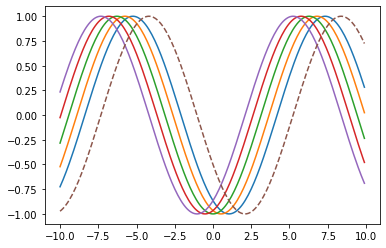

In [3]:
for i, task in enumerate(range(10,15)):
    
    X_qry = torch.Tensor(np.arange(-10, 10, 0.1)).reshape(-1,1)
    y_qry = f(X_qry, shift=task_shift(task))
    plt.plot(X_qry, y_qry)
    

X_qry = torch.Tensor(np.arange(-10, 10, 0.1)).reshape(-1,1)
y_qry = f(X_qry, shift=task_shift(8))

plt.plot(X_qry, y_qry, "--")


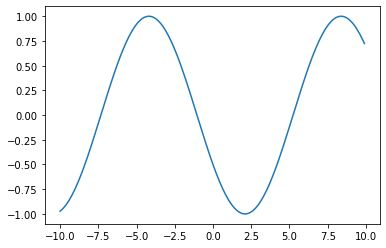

In [4]:
for task in range(8,9):
    
    X_qry = torch.Tensor(np.arange(-10, 10, 0.1)).reshape(-1,1)
    y_qry = f(X_qry, shift=task_shift(task))
    plt.plot(X_qry, y_qry)

In [5]:
torch.manual_seed(2)

DRE= dre.RankingLossSurrogate( 1, ssid="toy-NT", out_ds=10, hidden_dim_scorer=10, hidden_dim_ds = 10)
DRE.save_folder = ""


In [6]:
np.random.seed(0)
random.seed(29)
X_spt, y_spt, X_qry, y_qry = get_batch_test(spt_size=3, task = 8   )


tensor([-0.1200])
Last loss: tensor(0.7401, grad_fn=<MeanBackward0>)
0
tensor([-0.1200])
Last loss: tensor(1.0484, grad_fn=<MeanBackward0>)
85
tensor([-0.1500])
Last loss: tensor(1.1268, grad_fn=<MeanBackward0>)
81
tensor([-0.1900])
Last loss: tensor(1.5081, grad_fn=<MeanBackward0>)
78
tensor([-0.2200])
Last loss: tensor(0.5325, grad_fn=<MeanBackward0>)
74


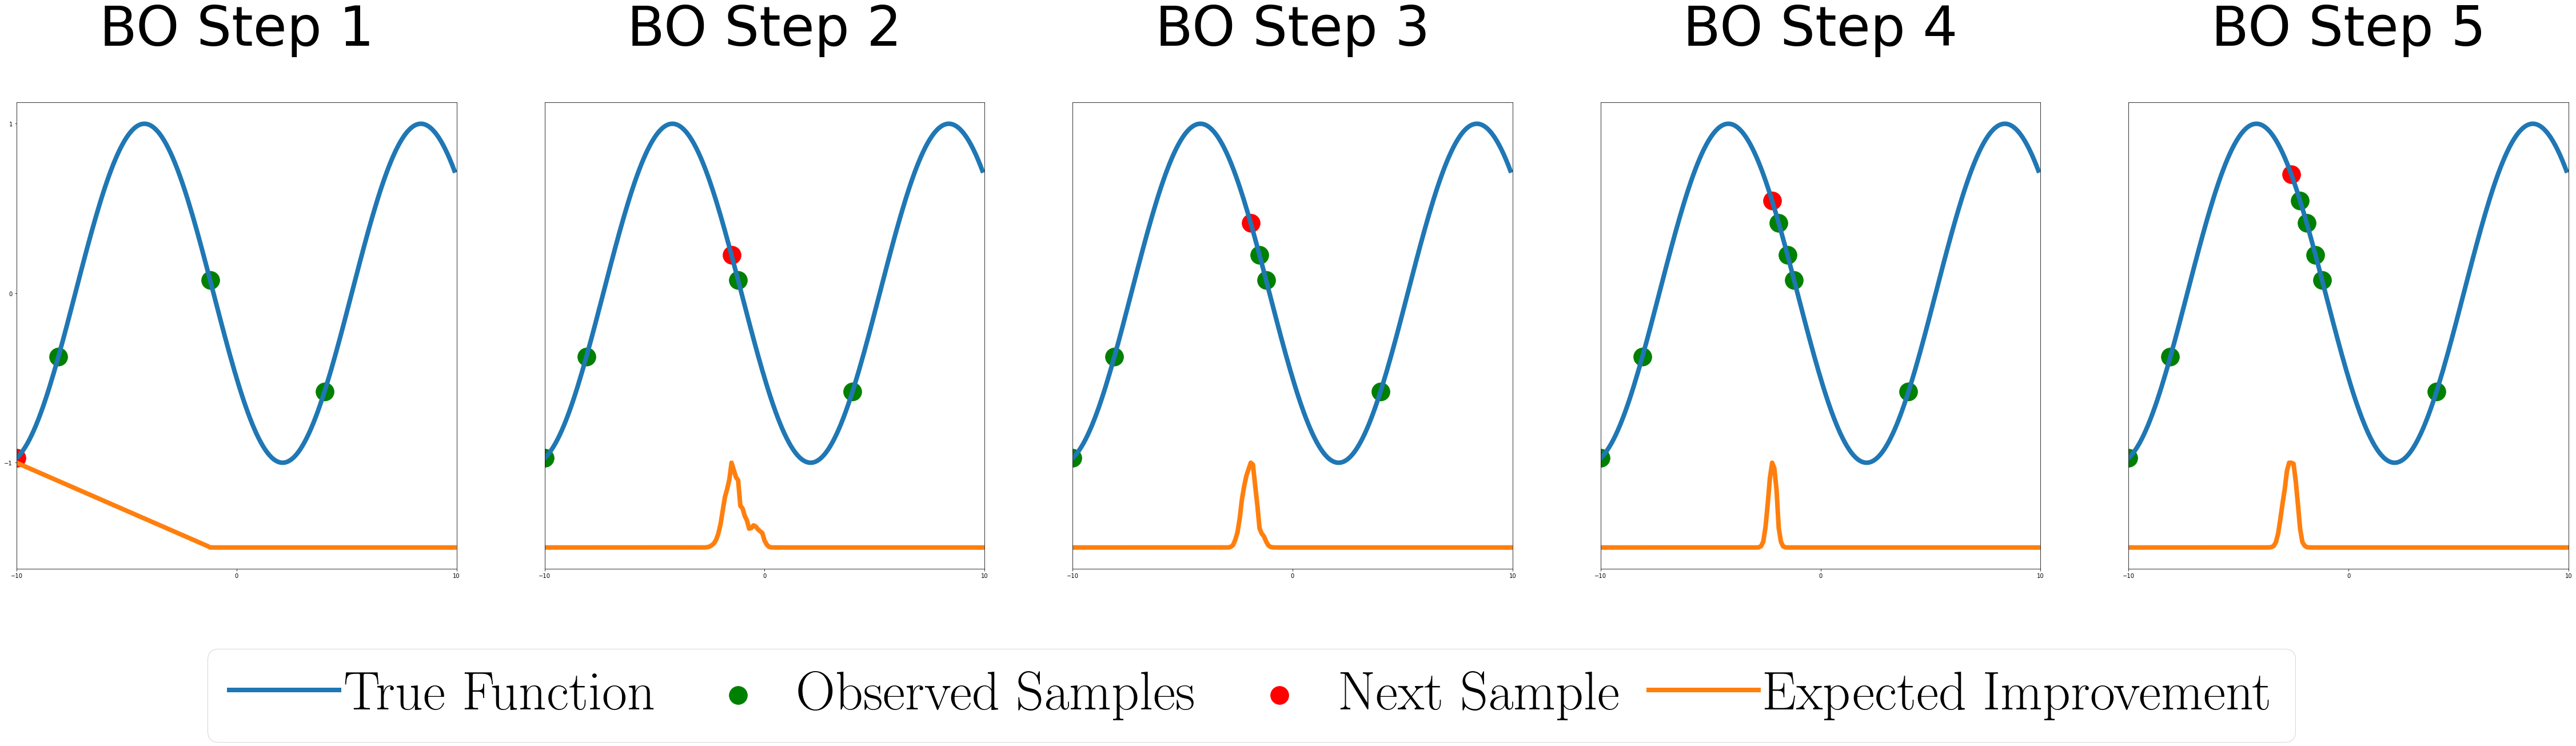

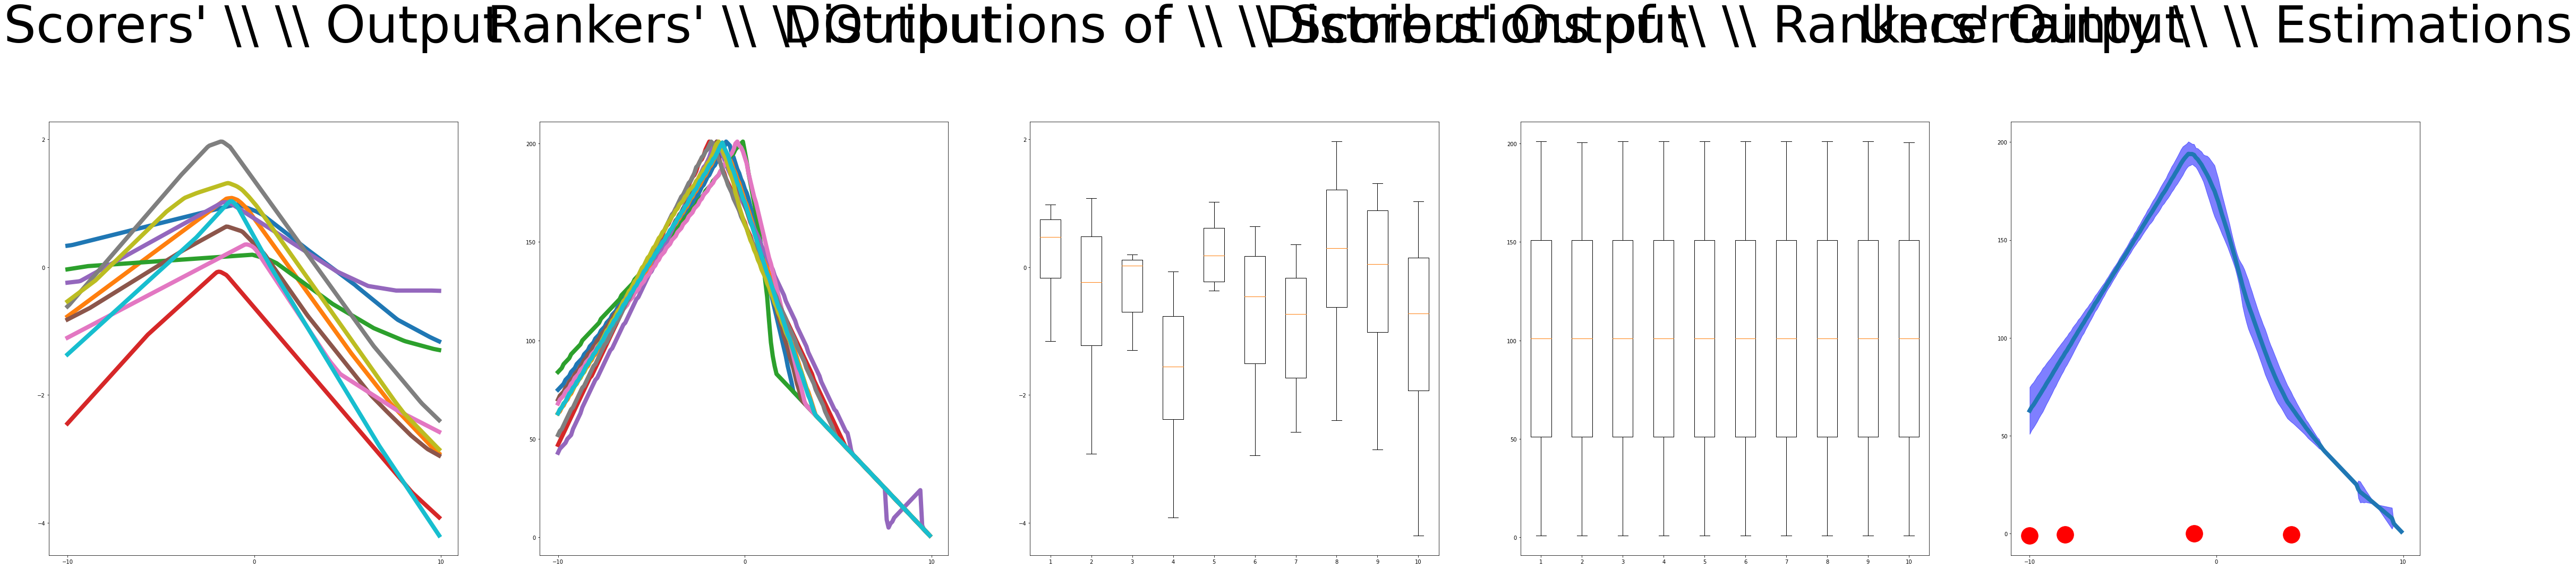

In [7]:
iterations = 5
lw = 8
factor=1.2
fontsize = 80

text_array = [r"BO Step 1", r"BO Step 2", r"BO Step 3" , r"BO Step 4", r"BO Step 5", r"BO Step 5"]

fig, axs = plt.subplots(1,iterations, figsize=(80,15))
fig2, axs2 = plt.subplots(1,iterations, figsize=(80,15))
matplotlib.rcParams.update({'font.size': fontsize, "text.usetex":True, 'font.family' : 'lmodern'})
for i in range(iterations):
                        
    incumbent = X_spt[y_spt.argmax()].reshape(-1)
    print(incumbent)
    DRE.fine_tune_together(X_spt, y_spt, epochs=500, lr=0.001)
    scores, mean, std, score_list= average_ranks_deep_set((X_spt, y_spt, X_qry), incumbent, DRE)
    idx_next = np.argmax(scores)
    print(idx_next)
    X_spt = torch.cat((X_spt, X_qry[idx_next].unsqueeze(-1)))
    y_spt = torch.cat((y_spt, y_qry[idx_next].unsqueeze(-1)))
    axs[i].plot(X_qry*10,y_qry, linewidth=lw, label=r"True Function")
    axs[i].scatter(X_spt[:-1]*10, y_spt[:-1], s= 1000, c= "green", label=r"Observed Samples")
    axs[i].scatter(X_spt[-1]*10, y_spt[-1], s= 1000, c= "red", label=r"Next Sample")
        

    ei = 0.5*scores/max(scores) -1.5
    axs[i].plot(X_qry*10, ei, linewidth=lw, label=r"Expected Improvement")
    axs[i].set_xlim(-10,10)


    axs[i].set_title(text_array[i], pad=100)
    
    if i>0:
        axs[i].set_yticks([]) 
    
    if i == 1:
        ranks = scipy.stats.rankdata(score_list, axis=-1)
        axs2[0].plot(X_qry*10, score_list[:,:-1].T, linewidth=lw)
        axs2[0].set_title(r"Scorers' \\ \\ Output", fontsize=fontsize*factor, pad=150)
        
        axs2[1].plot(X_qry*10,ranks[:,:-1].T,  linewidth=lw)
        axs2[1].set_title(r"Rankers' \\ \\ Output", fontsize=fontsize*factor, pad=150)
        
        whiskerprops = {'ls': 'solid', 'lw': 1}
        axs2[2].boxplot(score_list.T, whiskerprops=whiskerprops)
        axs2[2].set_title(r"Distributions of \\ \\ Scorers' Output", fontsize=fontsize*factor, pad=150)
        
        axs2[3].boxplot(ranks.T,  whiskerprops=whiskerprops)
        axs2[3].set_title(r"Distributions of \\ \\ Rankers' Output", fontsize=fontsize*factor, pad=150)
        
        axs2[4].plot(X_qry*10, mean, linewidth=lw)
        axs2[4].fill_between(X_qry.reshape(-1)*10, (mean-std), (mean+std), color='blue', alpha=0.5)    
        axs2[4].set_title(r"Uncertainty \\ \\ Estimations", fontsize=fontsize*factor, pad=150)
        axs2[4].scatter(X_spt[:-1]*10, y_spt[:-1], s= 1000, c= "red", label=r"Observed Samples")       
        
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes[:1]]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels,loc="lower center", bbox_to_anchor=(0.5, -0.2), ncol=4, fontsize=fontsize*factor,  handletextpad=0.1, labelspacing = 0.2, columnspacing=0.5)

fig.subplots_adjust(wspace=0.2)

fig.savefig("results/bo_steps_example_case.pdf", bbox_inches="tight")
fig2.savefig("results/modules_outputs_example_case.pdf", bbox_inches="tight")

tensor([-0.1200])
57


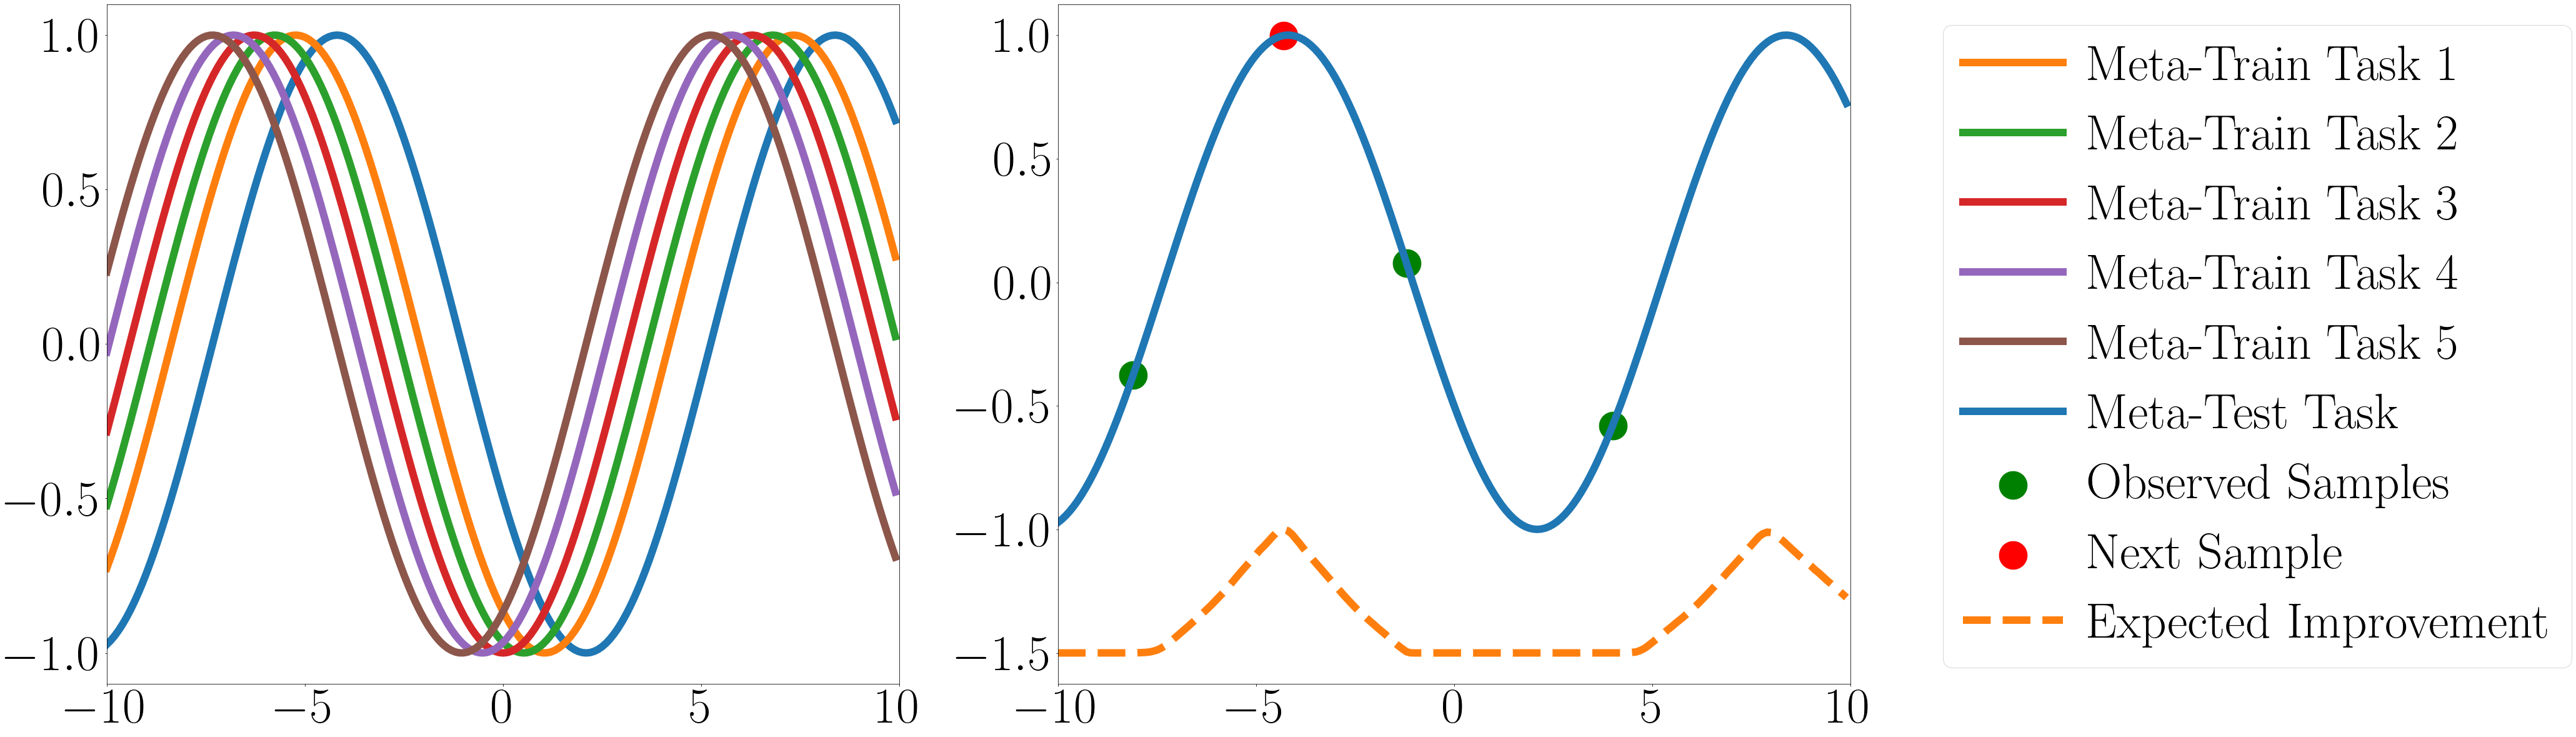

In [8]:
torch.manual_seed(0)
np.random.seed(0)
random.seed(29)
fontsize = 100
lw=12
X_spt, y_spt, X_qry, y_qry = get_batch_test(spt_size=3, task = 8   )

fig, axs = plt.subplots(1,2, figsize=(50,20))

#DRE was pretrained with the file deep_ranker_ensemble.py
DRE= dre.RankingLossSurrogate( 1, ssid="toy", out_ds=10, hidden_dim_scorer=10, hidden_dim_ds = 10)

incumbent = X_spt[y_spt.argmax()].reshape(-1)
print(incumbent)
DRE.load()
scores, mean, std, score_list= average_ranks_deep_set((X_spt, y_spt, X_qry), incumbent, DRE)
idx_next = np.argmax(scores)
print(idx_next)
X_spt = torch.cat((X_spt, X_qry[idx_next].unsqueeze(-1)))
y_spt = torch.cat((y_spt, y_qry[idx_next].unsqueeze(-1)))

axs[1].plot(X_qry*10,y_qry, linewidth=lw, label=r"Meta-Test Task")
axs[1].scatter(X_spt[:-1]*10, y_spt[:-1], s= 2000, c= "green", label=r"Observed Samples")
axs[1].scatter(X_spt[-1]*10, y_spt[-1], s= 2000, c= "red", label=r"Next Sample")

ei = scores/max(scores)
ei = 0.5*scores/max(scores) -1.5

axs[ 1].plot(X_qry*10, ei, "--",linewidth=lw, label=r"Expected Improvement")
axs[1].set_xlim(-10,10)

X_qry = torch.Tensor(np.arange(-10, 10, 0.1)).reshape(-1,1)
y_qry = f(X_qry, shift=task_shift(8))
axs[0].plot(X_qry, y_qry, linewidth=lw, label=r"\textbf{Meta-Test Task}")

task_names = [r"Meta-Train Task 1", r"Meta-Train Task 2", r"Meta-Train Task 3", r"Meta-Train Task 4", r"Meta-Train Task 5"]

for i, task in enumerate(range(10,15)):
    
    X_qry = torch.Tensor(np.arange(-10, 10, 0.1)).reshape(-1,1)
    y_qry = f(X_qry, shift=task_shift(task))
    axs[0].plot(X_qry, y_qry, linewidth=lw, label=task_names[i])
    axs[0].set_xlim(-10,10)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
lines.pop(0)
labels.pop(0)

anchor = (0.93, 0, 0.5, 1)
fig.legend(lines, labels,loc="center left", bbox_to_anchor=anchor, ncol=1, fontsize=fontsize*0.8,  handletextpad=0.5, labelspacing = 0.5, columnspacing=1.)
fig.subplots_adjust(wspace=0.2)
fig.savefig("results/meta_learning_example.pdf", bbox_inches="tight")